# Uncover the factors to help measure how young children learn

### Setting Up

In [2]:
# File system management
import os
import gc

# Numpy and pandas for data analysis and manipulation
import numpy as np
import pandas as pd

# Json for converting string to dict
import json

# Random for random
import random

# Datetime for handling date time variables
import datetime as dt

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from lightgbm import LGBMRegressor

# Sklearn importing folding methods
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

# Sklearn importing evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

# Hyper paramater optimisation
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin

# Weights and Biases for model control
import wandb

# tqdm for progress management
from tqdm import tqdm

In [26]:
# Setting up
config = {
    'method': 'LightGBM',
    'debug': False,
    'debug_train_size': 100,
    'debug_test_size': 50,
    'random_seed': 42,
    'num_trials': 20
}

## Functions

In [4]:
def ml_encoder(train, test, encode_columns, threshold=7, nan_as_category=True):
    """
    One-hot and label encoder with thresholds for categorical columns
    """
    # Union train and test to make sure all categories are represented
    df = pd.concat([train, test], ignore_index=True)
    
    # Unchanged columns
    keep_df = df[df.columns[~df.columns.isin(encode_columns)]]

    # Number of categories
    num_categories = df[encode_columns].describe(include='all').loc['unique']
    
    # Label encoding
    label_columns = num_categories.where(num_categories >= threshold).dropna().index
    le = LabelEncoder()
    label_df = df[label_columns].apply(lambda col: le.fit_transform(col))
    print(label_df.head())
    
    # One hot encoding
    one_hot_columns = num_categories.where(num_categories < threshold).dropna().index
    one_hot = [col for col in list(one_hot_columns) if df[col].dtype == 'object']
    one_hot_df = pd.get_dummies(df, columns=one_hot_columns, dummy_na=nan_as_category)
    print(one_hot_df.head())
    
    # Rebuild the dataframe
    df = pd.concat([keep_df, label_df, one_hot_df], axis=1)
    
    train = df.iloc[:len(train.index)]
    test = df.iloc[len(train.index):].reset_index().drop(columns=['index'])
    
    return train, test, le

In [5]:
# Using Ben Hamners quadratic weighted Kappa https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


### Importing Data

Can be commented out after the first run

In [6]:
# y_train = pd.read_csv("../data/train_labels.csv")
# # Saving full training set as feather
# y_train.reset_index().drop(columns = ['index']).to_feather("../data/y_train.feather")
# print(y_train.shape)
# # Creating sample for debuging
# sample = pd.Series(y_train['installation_id'].unique()).sample(config['debug_train_size'], random_state=config['random_seed'])
# y_train_sample = y_train.where(y_train['installation_id'].isin(sample)).dropna()
# y_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/y_train_sample.feather")
# print(y_train_sample.shape)

In [7]:
# X_train = pd.read_csv("../data/train.csv")
# # Droping ids that never had an assessment
# assessed = y_train['installation_id']
# X_train = X_train.where(X_train['installation_id'].isin(assessed)).dropna()
# # Saving full training set as feather
# X_train.reset_index().drop(columns = ['index']).to_feather("../data/X_train.feather")
# print(X_train.shape)
# # Creating sample for config['debug']ing
# X_train_sample = X_train.where(X_train['installation_id'].isin(sample)).dropna()
# X_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_train_sample.feather")
# print(X_train_sample.shape)

In [8]:
# X_test = pd.read_csv("../data/test.csv")
# # Saving full training set as feather
# X_test.reset_index().to_feather("../data/X_test.feather")
# print(X_test.shape)
# # Creating test sample for config['debug']ing
# test_sample = pd.Series(X_test['installation_id'].unique()).sample(config['debug_test_size'], random_state=config['random_seed'])
# X_test_sample = X_test.where(X_test['installation_id'].isin(test_sample)).dropna()
# X_test_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_test_sample.feather")
# print(X_test_sample.shape)

In [9]:
# # Loading training set from feather
if config['debug']:
    X_train = pd.read_feather("../data/X_train_sample.feather")
else:
    X_train = pd.read_feather("../data/X_train.feather")
X_train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,7d093bf9,6d37887a81d9ffd9,2019-09-01T21:12:38.242Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",01582211,1.0,2000.0,0.0,Chow Time,Game,CRYSTALCAVES
1,f93fc684,6d37887a81d9ffd9,2019-09-01T21:12:40.029Z,"{""coordinates"":{""x"":560,""y"":660,""stage_width"":...",01582211,2.0,4010.0,1833.0,Chow Time,Game,CRYSTALCAVES
2,7ec0c298,6d37887a81d9ffd9,2019-09-01T21:12:42.088Z,"{""description"":""It's Chow Time! We have some V...",01582211,3.0,3010.0,3883.0,Chow Time,Game,CRYSTALCAVES
3,0d1da71f,6d37887a81d9ffd9,2019-09-01T21:12:52.469Z,"{""description"":""It's Chow Time! We have some V...",01582211,4.0,3110.0,14267.0,Chow Time,Game,CRYSTALCAVES
4,63f13dd7,6d37887a81d9ffd9,2019-09-01T21:12:52.473Z,"{""dinosaur"":""daphne"",""diet"":""carnivore"",""targe...",01582211,5.0,2020.0,14267.0,Chow Time,Game,CRYSTALCAVES


In [10]:
# Meta data overview
X_train.describe(include='all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,201195,201195,201195,201195,201195,201195.000000,201195.000000,2.011950e+05,201195,201195,201195
unique,362,4589,191608,195755,100,NaN,NaN,NaN,44,4,4
top,5e3ea25a,39d2cbe5ce1896ea,2019-09-02T23:45:33.940Z,"{""event_code"": 2000, ""event_count"": 1}",35e704e6,NaN,NaN,NaN,Crystals Rule,Game,MAGMAPEAK
freq,6245,2177,4,2351,13532,NaN,NaN,NaN,17133,99769,78637
mean,NaN,NaN,NaN,NaN,NaN,104.582400,3522.319814,1.211032e+05,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,186.757951,672.537095,2.951896e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,2000.000000,0.000000e+00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,23.000000,3021.000000,2.790600e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,54.000000,4020.000000,6.313900e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,111.000000,4035.000000,1.322630e+05,NaN,NaN,NaN


In [27]:
# Loading training target set from feather
if config['debug']:
    y_train = pd.read_feather("../data/y_train_sample.feather")
else:
    y_train = pd.read_feather("../data/y_train.feather")
y_train.head(50)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.000000,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.500000,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.000000,3
5,197a373a77101924,0006c192,Cauldron Filler (Assessment),1,0,1.000000,3
6,957406a905d59afd,0006c192,Bird Measurer (Assessment),1,1,0.500000,2
7,b2297d292892745a,0006c192,Mushroom Sorter (Assessment),0,4,0.000000,0
8,ae691ec5ad5652cf,00129856,Bird Measurer (Assessment),1,0,1.000000,3
9,7b536271e99518f0,001d0ed0,Bird Measurer (Assessment),0,5,0.000000,0


In [28]:
# Meta data overview
y_train.describe(include='all') # game_session is unique on the assessments

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
count,17690,17690,17690,17690.000000,17690.000000,17690.000000,17690.000000
unique,17690,3614,5,NaN,NaN,NaN,NaN
top,fbd3e35d086ce391,08987c08,Cart Balancer (Assessment),NaN,NaN,NaN,NaN
freq,1,156,4151,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.760938,1.587790,0.595810,1.885585
std,NaN,NaN,NaN,0.426523,3.058295,0.430559,1.256796
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,1.000000,0.000000,0.111111,1.000000
50%,NaN,NaN,NaN,1.000000,0.500000,0.750000,2.500000
75%,NaN,NaN,NaN,1.000000,2.000000,1.000000,3.000000


In [14]:
# Loading testing set from feather
if config['debug']:
    X_test = pd.read_feather("../data/X_test_sample.feather")
else:
    X_test = pd.read_feather("../data/X_test.feather")
X_test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0f50720cd6907c01,2019-08-26T15:55:45.576Z,"{""event_code"": 2000, ""event_count"": 1}",12771ee9,1.0,2000.0,0.0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,66f8916b5f7a449c,2019-08-26T15:56:11.605Z,"{""event_code"": 2000, ""event_count"": 1}",12771ee9,1.0,2000.0,0.0,Tree Top City - Level 1,Clip,TREETOPCITY
2,3bfd1a65,a950eb8370e668c0,2019-08-26T15:57:06.457Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",12771ee9,1.0,2000.0,0.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
3,db02c830,a950eb8370e668c0,2019-08-26T15:57:06.513Z,"{""event_count"":2,""game_time"":0,""event_code"":2025}",12771ee9,2.0,2025.0,0.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
4,a1e4395d,a950eb8370e668c0,2019-08-26T15:57:06.519Z,"{""description"":""Pull three mushrooms out of th...",12771ee9,3.0,3010.0,0.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [15]:
# X_train['datetime'] = [dt.replace(tzinfo=None) for dt in pd.to_datetime(X_train.timestamp)]
# X_test['datetime'] = [dt.replace(tzinfo=None) for dt in pd.to_datetime(X_test.timestamp)]

In [108]:
# X_train['weekday'] = X_train.datetime.dt.weekday
# X_test['weekday'] = X_test.datetime.dt.weekday

In [109]:
# X_train['time']  = X_train.datetime.dt.hour
# X_test['time']  = X_test.datetime.dt.hour

In [110]:
# X_train['month'] = X_train.datetime.dt.month
# X_test['month'] = X_test.datetime.dt.month

In [111]:
# X_train['ordinal_date'] = [x.toordinal() for x in X_train.datetime]
# X_test['ordinal_date'] = [x.toordinal() for x in X_test.datetime]

In [113]:
# # Time since last and untill next event (we seem to have information about the future availible in the test set)
# X_train['time_prev_event'] = (
#         X_train.groupby('installation_id').datetime.shift(1) - X_train.datetime
#     ).astype(np.int64)//1e9//60//60
# X_test['time_prev_event'] = (
#         X_test.groupby('installation_id').datetime.shift(1) - X_test.datetime
#     ).astype(np.int64)//1e9//60//60

In [88]:
# Some event_codes are the same for different titles
# X_train['title.event_code'] = X_train[['title', 'event_code']].apply(lambda x: ''.join(str(x)), axis=1)
# X_test['title.event_code'] = X_test[['title', 'event_code']].apply(lambda x: ''.join(str(x)), axis=1)

In [116]:
# X_train.sort_values(by=['datetime'], inplace=True)
# X_test.sort_values(by=['datetime'], inplace=True)

In [14]:
# Meta data overview
X_test.describe(include='all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,81884,81884,81884,81884,81884,81884.000000,81884.000000,8.188400e+04,81884,81884,81884
unique,351,1492,78583,80242,50,NaN,NaN,NaN,44,4,4
top,1325467d,b246933e8ac6a4aa,2019-09-28T01:27:59.191Z,"{""event_code"": 2000, ""event_count"": 1}",e6862711,NaN,NaN,NaN,Scrub-A-Dub,Game,MAGMAPEAK
freq,5511,4456,4,744,12128,NaN,NaN,NaN,11284,37656,39262
mean,NaN,NaN,NaN,NaN,NaN,287.848200,3571.288335,2.030262e+05,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,663.954337,663.935095,1.012415e+06,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,2000.000000,0.000000e+00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,31.000000,3110.000000,3.162350e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,79.000000,4021.000000,7.045900e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,191.000000,4070.000000,1.416380e+05,NaN,NaN,NaN


In [15]:
gc.collect()

29

### Exploring the data

In [45]:
# Unrealistically the date in the datasets has a large overlap
print(f"Min train date: {X_train['timestamp'].min()}, Max train date: {X_train['timestamp'].max()}")
print(f"Min test date: {X_test['timestamp'].min()}, Max test date: {X_test['timestamp'].max()}")

Min train date: 2019-07-23T17:00:40.282Z, Max train date: 2019-10-14T19:09:04.756Z
Min test date: 2019-07-26T01:27:28.052Z, Max test date: 2019-10-13T19:13:56.450Z


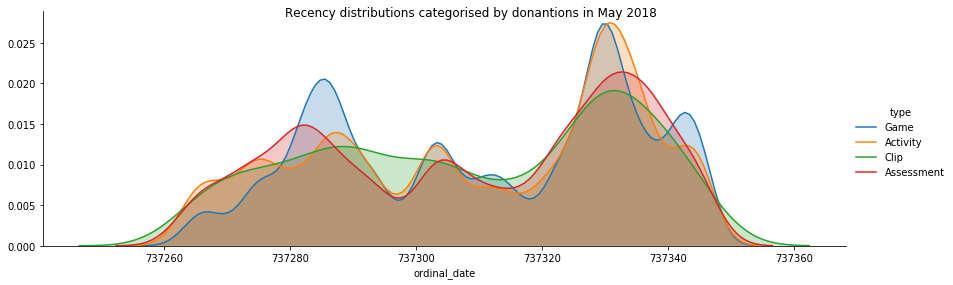

In [52]:
# Plotting the distributions of type by time
X_train['ordinal_date'] = [x.toordinal() for x in pd.to_datetime(X_train.timestamp)]
# print(X_train.ordinal_date.tail())
recency = sns.FacetGrid(X_train, hue = 'type', height=4, aspect=3)
recency.map(sns.kdeplot, 'ordinal_date', shade= True)
# recency.set(xlim=(X_train['date'].min() , X_train['date'].max()))
recency.fig.suptitle('Recency distributions categorised by donantions in May 2018')
recency.add_legend()

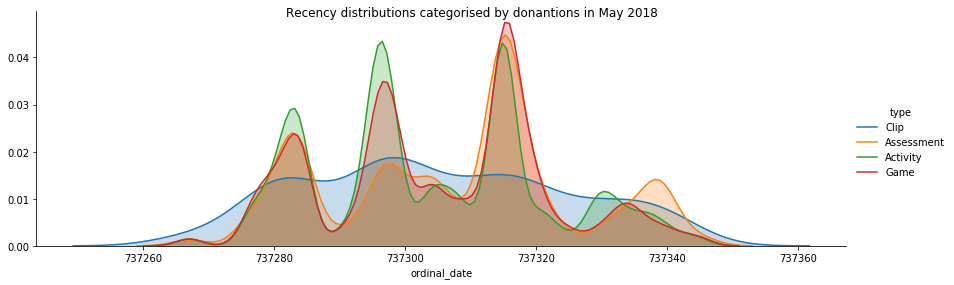

In [53]:
# Plotting the distributions of type by time
X_test['ordinal_date'] = [x.toordinal() for x in pd.to_datetime(X_test.timestamp)]
# print(X_train.ordinal_date.tail())
recency = sns.FacetGrid(X_test, hue = 'type', height=4, aspect=3)
recency.map(sns.kdeplot, 'ordinal_date', shade= True)
# recency.set(xlim=(X_train['date'].min() , X_train['date'].max()))
recency.fig.suptitle('Recency distributions categorised by donantions in May 2018')
recency.add_legend()

In [59]:
# Checking If there is any overlap of installation IDs
set(X_train.installation_id.unique()).intersection(set(X_test.installation_id.unique()))

set()

In [63]:
# Looking at a specific id
id_01582211 = X_train.where(X_train.installation_id == '01582211').dropna()
id_01582211.tail(10)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,int_timestamp,ordinal_date
2201,d3268efa,2b06dcf3a9bc9ab5,2019-10-13T12:35:57.717Z,"{""description"":""Look! Each bucket is exactly t...",01582211,23.0,3021.0,14479.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:35:57.717000+00:00,20191013.0,737345.0
2202,b5053438,2b06dcf3a9bc9ab5,2019-10-13T12:36:03.703Z,"{""description"":""Look! Each bucket is exactly t...",01582211,24.0,3121.0,20480.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:36:03.703000+00:00,20191013.0,737345.0
2203,923afab1,2b06dcf3a9bc9ab5,2019-10-13T12:36:03.710Z,"{""description"":""Okay. Tap the bucket that hold...",01582211,25.0,3010.0,20480.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:36:03.710000+00:00,20191013.0,737345.0
2204,532a2afb,2b06dcf3a9bc9ab5,2019-10-13T12:36:03.710Z,"{""buckets"":[],""target_bucket"":3,""mode"":""select...",01582211,26.0,2020.0,20480.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:36:03.710000+00:00,20191013.0,737345.0
2205,2dcad279,2b06dcf3a9bc9ab5,2019-10-13T12:36:07.109Z,"{""description"":""Okay. Tap the bucket that hold...",01582211,27.0,3110.0,23880.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:36:07.109000+00:00,20191013.0,737345.0
2206,91561152,2b06dcf3a9bc9ab5,2019-10-13T12:36:08.009Z,"{""bucket"":3,""buckets_placed"":[3,1,2],""target_b...",01582211,28.0,4025.0,24780.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:36:08.009000+00:00,20191013.0,737345.0
2207,28520915,2b06dcf3a9bc9ab5,2019-10-13T12:36:08.010Z,"{""misses"":0,""prompt"":""holds most"",""mode"":""sele...",01582211,29.0,2030.0,24780.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:36:08.010000+00:00,20191013.0,737345.0
2208,d3268efa,2b06dcf3a9bc9ab5,2019-10-13T12:36:08.015Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",01582211,30.0,3021.0,24780.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:36:08.015000+00:00,20191013.0,737345.0
2209,b5053438,2b06dcf3a9bc9ab5,2019-10-13T12:36:08.737Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",01582211,31.0,3121.0,25514.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:36:08.737000+00:00,20191013.0,737345.0
2210,27253bdc,820c4dcff03a22ff,2019-10-13T12:36:43.355Z,"{""event_code"": 2000, ""event_count"": 1}",01582211,1.0,2000.0,0.0,Tree Top City - Level 1,Clip,TREETOPCITY,2019-10-13 12:36:43.355000+00:00,20191013.0,737345.0


In [72]:
# Scored assessment events
id_01582211.where(((id_01582211.type == 'Assessment') & (id_01582211.event_code == 4100)) | ((id_01582211.title == 'Bird Measurer (Assessment)') & (id_01582211.event_code == 4110))).dropna()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,int_timestamp,ordinal_date
448,d122731b,b9e4e0faa3d91e1f,2019-09-01T21:26:57.868Z,"{""correct"":false,""left"":[{""id"":""gem06"",""weight...",01582211,12.0,4100.0,14252.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:26:57.868000+00:00,20190901.0,737303.0
459,d122731b,b9e4e0faa3d91e1f,2019-09-01T21:27:07.394Z,"{""correct"":true,""left"":[{""id"":""gem06"",""weight""...",01582211,23.0,4100.0,23786.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:27:07.394000+00:00,20190901.0,737303.0
1034,93b353f2,ef94f97ffa892216,2019-09-01T21:44:29.141Z,"{""correct"":false,""pillars"":[2,3,1],""event_coun...",01582211,44.0,4100.0,49173.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:44:29.141000+00:00,20190901.0,737303.0
1042,93b353f2,ef94f97ffa892216,2019-09-01T21:44:38.358Z,"{""correct"":false,""pillars"":[3,1,2],""event_coun...",01582211,52.0,4100.0,58390.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:44:38.358000+00:00,20190901.0,737303.0
1068,93b353f2,ef94f97ffa892216,2019-09-01T21:45:10.954Z,"{""correct"":false,""pillars"":[0,0,0],""event_coun...",01582211,78.0,4100.0,90993.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:45:10.954000+00:00,20190901.0,737303.0
1081,93b353f2,ef94f97ffa892216,2019-09-01T21:45:24.131Z,"{""correct"":false,""pillars"":[3,1,2],""event_coun...",01582211,91.0,4100.0,104160.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:45:24.131000+00:00,20190901.0,737303.0
1528,d122731b,0d641058b46d3689,2019-10-05T22:34:55.855Z,"{""correct"":true,""left"":[{""id"":""gem05"",""weight""...",01582211,18.0,4100.0,12576.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,2019-10-05 22:34:55.855000+00:00,20191005.0,737337.0
1711,93b353f2,902c22638fceb254,2019-10-06T13:12:18.591Z,"{""correct"":false,""pillars"":[2,3,1],""event_coun...",01582211,25.0,4100.0,20425.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-10-06 13:12:18.591000+00:00,20191006.0,737338.0
1716,93b353f2,902c22638fceb254,2019-10-06T13:12:21.970Z,"{""correct"":false,""pillars"":[2,1,3],""event_coun...",01582211,30.0,4100.0,23808.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-10-06 13:12:21.970000+00:00,20191006.0,737338.0
2196,392e14df,2b06dcf3a9bc9ab5,2019-10-13T12:35:55.859Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",01582211,18.0,4100.0,12630.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-10-13 12:35:55.859000+00:00,20191013.0,737345.0


In [73]:
# In the training sets we have multiple events before and after the assessment
id_01582211.where(id_01582211.game_session == 'ef94f97ffa892216').dropna()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,int_timestamp,ordinal_date
991,5b49460a,ef94f97ffa892216,2019-09-01T21:43:39.990Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01582211,1.0,2000.0,0.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:43:39.990000+00:00,20190901.0,737303.0
992,155f62a4,ef94f97ffa892216,2019-09-01T21:43:40.341Z,"{""event_count"":2,""game_time"":386,""event_code"":...",01582211,2.0,2020.0,386.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:43:40.341000+00:00,20190901.0,737303.0
993,3dcdda7f,ef94f97ffa892216,2019-09-01T21:43:40.349Z,"{""description"":""Order the treasure chests from...",01582211,3.0,3010.0,386.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:43:40.349000+00:00,20190901.0,737303.0
994,3ccd3f02,ef94f97ffa892216,2019-09-01T21:43:42.920Z,"{""description"":""Order the treasure chests from...",01582211,4.0,3110.0,2970.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:43:42.920000+00:00,20190901.0,737303.0
995,3dcdda7f,ef94f97ffa892216,2019-09-01T21:43:42.927Z,"{""description"":""Use this pan balance to weigh ...",01582211,5.0,3010.0,2970.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:43:42.927000+00:00,20190901.0,737303.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,a8efe47b,ef94f97ffa892216,2019-09-01T21:45:22.476Z,"{""weight"":1,""pillars"":[3,0,2],""coordinates"":{""...",01582211,89.0,4030.0,102510.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:45:22.476000+00:00,20190901.0,737303.0
1080,0db6d71d,ef94f97ffa892216,2019-09-01T21:45:23.140Z,"{""weight"":1,""destination"":""Heavy"",""coordinates...",01582211,90.0,4020.0,103193.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:45:23.140000+00:00,20190901.0,737303.0
1081,93b353f2,ef94f97ffa892216,2019-09-01T21:45:24.131Z,"{""correct"":false,""pillars"":[3,1,2],""event_coun...",01582211,91.0,4100.0,104160.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:45:24.131000+00:00,20190901.0,737303.0
1082,ea296733,ef94f97ffa892216,2019-09-01T21:45:24.132Z,"{""description"":""Try weighing the chests again....",01582211,92.0,3020.0,104160.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,2019-09-01 21:45:24.132000+00:00,20190901.0,737303.0


In [68]:
y_train.where(y_train.game_session == 'ef94f97ffa892216').dropna()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
4,ef94f97ffa892216,01582211,Chest Sorter (Assessment),0.0,4.0,0.0,0.0


In [18]:
X_test.installation_id.unique()

array(['12771ee9', '15f9b137', '1b5d84df', '1d2eae73', '26b5e264',
       '274f2012', '2e6923d6', '36025ee6', '37db1bb3', '4108ffbd',
       '4be715ec', '4cd1add0', '5090c28a', '52ac2e43', '55bf8834',
       '587b89b2', '5d3d2ce3', '6586f9f0', '65b92dd5', '6f6269a6',
       '773d63e3', '8551489a', '8854354f', '89bda256', '8b29ddb4',
       '8fe03c35', '97501794', '9bb426a7', '9f688c66', 'a0808b82',
       'a3a93b63', 'aab22722', 'af47aac5', 'b0efc6f4', 'bd2e184f',
       'bd544e63', 'c3cabf93', 'd0ca8163', 'd630ee07', 'dd9a2277',
       'e2246114', 'e6862711', 'e6ea5608', 'e6eefaf1', 'ebd77787',
       'f031811a', 'f2ce44bc', 'f842b8b3', 'f86a6ed4', 'fc0367c0'],
      dtype=object)

In [25]:
# Specific test id
id_f86a6ed4 = X_test.where(X_test.installation_id == 'f86a6ed4').dropna().sort_values('timestamp')
id_f86a6ed4.tail(50)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
78368,bb3e370b,d286961a17219e36,2019-08-27T22:36:35.407Z,"{""bottle"":{""amount"":2,""color"":""orange""},""bottl...",f86a6ed4,229.0,4030.0,496919.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78369,90efca10,d286961a17219e36,2019-08-27T22:36:36.424Z,"{""bottle"":{""amount"":2,""color"":""orange""},""bottl...",f86a6ed4,230.0,4020.0,497998.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78370,e9c52111,d286961a17219e36,2019-08-27T22:36:41.217Z,"{""jar"":[{""color"":""orange"",""amount"":2}],""durati...",f86a6ed4,231.0,2030.0,502791.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78371,b7530680,d286961a17219e36,2019-08-27T22:36:41.220Z,"{""previous_jars"":[[{""color"":""orange"",""amount"":...",f86a6ed4,232.0,2020.0,502791.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78372,bb3e370b,d286961a17219e36,2019-08-27T22:36:45.700Z,"{""bottle"":{""amount"":2,""color"":""orange""},""bottl...",f86a6ed4,233.0,4030.0,507214.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78373,67439901,d286961a17219e36,2019-08-27T22:36:46.424Z,"{""description"":""Ooo, stripes!"",""identifier"":""o...",f86a6ed4,234.0,3010.0,507990.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78374,90efca10,d286961a17219e36,2019-08-27T22:36:46.428Z,"{""bottle"":{""amount"":2,""color"":""orange""},""bottl...",f86a6ed4,235.0,4020.0,507990.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78375,df4940d3,d286961a17219e36,2019-08-27T22:36:48.617Z,"{""description"":""Ooo, stripes!"",""identifier"":""o...",f86a6ed4,236.0,3110.0,510179.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78376,bb3e370b,d286961a17219e36,2019-08-27T22:36:50.181Z,"{""bottle"":{""amount"":1,""color"":""orange""},""bottl...",f86a6ed4,237.0,4030.0,511704.0,Bottle Filler (Activity),Activity,MAGMAPEAK
78377,90efca10,d286961a17219e36,2019-08-27T22:36:51.155Z,"{""bottle"":{""amount"":1,""color"":""orange""},""bottl...",f86a6ed4,238.0,4020.0,512725.0,Bottle Filler (Activity),Activity,MAGMAPEAK


In [100]:
# Scored assessment events
id_e6862711_assess = id_e6862711.where(((id_e6862711.type == 'Assessment') 
                                        & (id_e6862711.event_code == 4100)) 
                                       | ((id_e6862711.title == 'Bird Measurer (Assessment)') 
                                         & (id_e6862711.event_code == 4110))).dropna()
id_e6862711_assess.tail(30)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,ordinal_date
55809,392e14df,cda34c7ff28dfc45,2019-09-13T00:35:14.612Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",e6862711,13.0,4100.0,13029.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,737315.0
55931,d122731b,89bc44543fb9d70a,2019-09-13T00:43:46.108Z,"{""correct"":false,""left"":[{""id"":""gem08"",""weight...",e6862711,26.0,4100.0,20637.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,737315.0
55938,d122731b,89bc44543fb9d70a,2019-09-13T00:43:55.026Z,"{""correct"":true,""left"":[{""id"":""gem08"",""weight""...",e6862711,33.0,4100.0,29554.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,737315.0
56299,93b353f2,f988b91774fa6d0a,2019-09-13T00:58:47.220Z,"{""correct"":false,""pillars"":[],""event_count"":22...",e6862711,22.0,4100.0,18886.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,737315.0
56312,93b353f2,f988b91774fa6d0a,2019-09-13T00:59:00.434Z,"{""correct"":false,""pillars"":[0],""event_count"":3...",e6862711,35.0,4100.0,32102.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,737315.0
56336,93b353f2,f988b91774fa6d0a,2019-09-13T00:59:20.250Z,"{""correct"":false,""pillars"":[0],""event_count"":5...",e6862711,59.0,4100.0,51912.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,737315.0
56369,93b353f2,f988b91774fa6d0a,2019-09-13T00:59:40.503Z,"{""correct"":false,""pillars"":[0],""event_count"":9...",e6862711,92.0,4100.0,72173.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,737315.0
56441,93b353f2,f988b91774fa6d0a,2019-09-13T01:00:19.697Z,"{""correct"":false,""pillars"":[0,0],""event_count""...",e6862711,164.0,4100.0,111360.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,737315.0
56464,93b353f2,f988b91774fa6d0a,2019-09-13T01:01:02.322Z,"{""correct"":false,""pillars"":[0,1],""event_count""...",e6862711,187.0,4100.0,153993.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,737315.0
56489,93b353f2,f988b91774fa6d0a,2019-09-13T01:01:40.542Z,"{""correct"":false,""pillars"":[0,0],""event_count""...",e6862711,212.0,4100.0,192212.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,737315.0


In [91]:
# We have events from after the assessment events???
id_e6862711.timestamp.max()

'2019-09-21T12:51:51.773Z'

In [93]:
id_e6862711.where(id_e6862711.timestamp == '2019-09-21T12:51:51.773Z').dropna()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,ordinal_date
62254,90d848e0,3ddb1d916b1ab2d4,2019-09-21T12:51:51.773Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",e6862711,1.0,2000.0,0.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,737323.0


In [97]:
print(id_e6862711.where(id_e6862711.timestamp == '2019-09-21T12:51:51.773Z').dropna().event_data.to_dict())

{62254: '{"version":"1.0","event_count":1,"game_time":0,"event_code":2000}'}


In [101]:
id_e6862711.where(id_e6862711.timestamp > '2019-09-13T22:20:25.786Z').dropna()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,ordinal_date
61963,160654fd,c66b6a69ad444500,2019-09-13T22:20:25.792Z,"{""description"":""Drag the mushrooms to the tree...",e6862711,21.0,3020.0,24956.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,737315.0
61964,88d4a5be,c66b6a69ad444500,2019-09-13T22:20:27.693Z,"{""description"":""Drag the mushrooms to the tree...",e6862711,22.0,3120.0,26878.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,737315.0
61965,7da34a02,c66b6a69ad444500,2019-09-13T22:20:27.918Z,"{""coordinates"":{""x"":304,""y"":492,""stage_width"":...",e6862711,23.0,4070.0,27088.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,737315.0
61966,7da34a02,c66b6a69ad444500,2019-09-13T22:20:27.948Z,"{""coordinates"":{""x"":338,""y"":536,""stage_width"":...",e6862711,24.0,4070.0,27088.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,737315.0
61967,7da34a02,c66b6a69ad444500,2019-09-13T22:20:27.996Z,"{""coordinates"":{""x"":334,""y"":492,""stage_width"":...",e6862711,25.0,4070.0,27166.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,737315.0
...,...,...,...,...,...,...,...,...,...,...,...,...
62250,7da34a02,6922a795aab58547,2019-09-13T22:35:41.038Z,"{""coordinates"":{""x"":747,""y"":309,""stage_width"":...",e6862711,43.0,4070.0,13716.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,737315.0
62251,7da34a02,6922a795aab58547,2019-09-13T22:35:41.049Z,"{""coordinates"":{""x"":747,""y"":309,""stage_width"":...",e6862711,44.0,4070.0,13716.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,737315.0
62252,7da34a02,6922a795aab58547,2019-09-13T22:35:41.213Z,"{""coordinates"":{""x"":708,""y"":257,""stage_width"":...",e6862711,45.0,4070.0,14399.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,737315.0
62253,27253bdc,eef3cff02a0f98bb,2019-09-21T12:50:56.490Z,"{""event_code"": 2000, ""event_count"": 1}",e6862711,1.0,2000.0,0.0,Magma Peak - Level 2,Clip,MAGMAPEAK,737323.0


In [81]:
print('num unique event_ids:', X_train.event_id.unique().shape)
print('num unique event_ids:', X_test.event_id.unique().shape)

num unique event_ids: (362,)
num unique event_ids: (351,)


In [105]:
print('num event_ids:', X_train.event_id.shape)
print('num event_ids:', X_test.event_id.shape)

num event_ids: (201195,)
num event_ids: (81884,)


In [86]:
print('num unique event_id by code:', X_train[['event_code', 'event_id']].drop_duplicates().shape)
print('num unique event_id by code:', X_test[['event_code', 'event_id']].drop_duplicates().shape)

num unique event_id by code: (362, 2)
num unique event_id by code: (351, 2)


In [87]:
# there is some overlap of event codes and titles
print('num unique title by code:', X_train[['title', 'event_code']].drop_duplicates().shape)
print('num unique title by code:', X_test[['title', 'event_code']].drop_duplicates().shape)

num unique title by code: (381, 2)
num unique title by code: (370, 2)


In [90]:
# looking at titles
X_train.where(X_train.title == 'Bird Measurer (Assessment)').dropna().head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
663,f56e0afc,6c8fab7964639f37,2019-08-10T18:12:28.453Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00e17272,1.0,2000.0,0.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
664,ec138c1c,6c8fab7964639f37,2019-08-10T18:12:28.503Z,"{""stage_number"":1,""event_count"":2,""game_time"":...",00e17272,2.0,2020.0,0.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
665,1375ccb7,6c8fab7964639f37,2019-08-10T18:12:28.506Z,"{""description"":""Use the caterpillars to measur...",00e17272,3.0,3010.0,0.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
666,bdf49a58,6c8fab7964639f37,2019-08-10T18:12:33.096Z,"{""description"":""Use the caterpillars to measur...",00e17272,4.0,3110.0,4695.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
667,51102b85,6c8fab7964639f37,2019-08-10T18:12:33.328Z,"{""hat"":0,""caterpillar"":""left"",""coordinates"":{""...",00e17272,5.0,4030.0,4911.0,Bird Measurer (Assessment),Assessment,TREETOPCITY


In [154]:
# Chcking the number of assessments
X_train_assessed = X_train.where(((X_train.type == 'Assessment') & (X_train.event_code == 4100)) | ((X_train.title == 'Bird Measurer (Assessment)') & (X_train.event_code == 4110))).dropna()
X_train_assessed.describe(include = 'all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,3523,3523,3523,3523,3523,3523.000000,3523.000000,3.523000e+03,3523,3523,3523
unique,6,1276,3523,3522,97,NaN,NaN,NaN,5,1,3
top,392e14df,7136d0fb1283ae19,2019-09-11T14:47:26.592Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",08987c08,NaN,NaN,NaN,Cauldron Filler (Assessment),Assessment,TREETOPCITY
freq,934,36,1,2,593,NaN,NaN,NaN,934,3523,1474
mean,NaN,NaN,NaN,NaN,NaN,44.873403,4102.128867,7.397595e+04,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,42.781803,4.094063,4.448047e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,4.000000,4100.000000,1.748000e+03,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,4100.000000,1.752050e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,33.000000,4100.000000,2.996700e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,54.000000,4100.000000,5.454150e+04,NaN,NaN,NaN


In [155]:
# Getting the final entry for each game_session
idx = X_train_assessed.groupby(['game_session'])['event_count'].transform(max) == X_train_assessed['event_count']
X_train_assessed_last_session_event = X_train_assessed[idx]
X_train_assessed_last_session_event.describe(include = 'all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,1276,1276,1276,1276,1276,1276.000000,1276.000000,1.276000e+03,1276,1276,1276
unique,6,1276,1276,1275,97,NaN,NaN,NaN,5,1,3
top,392e14df,40dbb48704146431,2019-09-10T18:22:45.667Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",08987c08,NaN,NaN,NaN,Cauldron Filler (Assessment),Assessment,CRYSTALCAVES
freq,316,1,1,2,156,NaN,NaN,NaN,316,1276,496
mean,NaN,NaN,NaN,NaN,NaN,40.387147,4100.705329,6.601858e+04,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,36.511709,2.561434,3.509608e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,4.000000,4100.000000,2.031000e+03,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,18.000000,4100.000000,1.686725e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,32.000000,4100.000000,2.801600e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,49.000000,4100.000000,5.043200e+04,NaN,NaN,NaN


In [109]:
X_train_assessed_last_session_event.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
377,392e14df,9444d34477d7f2c5,2019-08-10T18:02:42.206Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",00e17272,40.0,4100.0,38307.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
404,392e14df,a8c4aa084792d9bc,2019-08-10T18:03:24.464Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",00e17272,13.0,4100.0,8389.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
503,25fa8af4,b1fa320f360a5df7,2019-08-10T18:07:26.756Z,"{""correct"":true,""stumps"":[2,3,5],""event_count""...",00e17272,32.0,4100.0,26065.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
709,070a5291,6c8fab7964639f37,2019-08-10T18:13:22.509Z,"{""correct"":true,""hats"":[4,8,5],""event_count"":4...",00e17272,47.0,4100.0,54099.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
827,392e14df,a8f34c37b52dcf4e,2019-08-10T18:18:27.391Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",00e17272,13.0,4100.0,7787.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


In [112]:
X_train_session_not_assessed = X_train.where((X_train.type == 'Assessment') & ~X_train.game_session.isin(y_train.game_session)).dropna()
X_train_session_not_assessed.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1471,7ad3efc6,9837bf9935e06e0b,2019-08-11T12:19:21.079Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00e17272,1.0,2000.0,0.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1472,65a38bf7,9837bf9935e06e0b,2019-08-11T12:19:21.151Z,"{""crystals"":[{""id"":""gem07"",""weight"":6},{""id"":""...",00e17272,2.0,2020.0,47.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1473,795e4a37,9837bf9935e06e0b,2019-08-11T12:19:21.157Z,"{""description"":""We've got to balance this scal...",00e17272,3.0,3010.0,47.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
6561,3bfd1a65,ad52e0640c0b3415,2019-08-05T23:02:57.138Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",08987c08,1.0,2000.0,0.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
6562,db02c830,ad52e0640c0b3415,2019-08-05T23:02:57.206Z,"{""event_count"":2,""game_time"":46,""event_code"":2...",08987c08,2.0,2025.0,46.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [115]:
# There are some assessment game_sessions where there was no final assessment (possibly?) because the assesment was not finished so didn't end up in the target set. It could be very powerful to know if there have been prior uncompleated attemts at the 
# assessments. If there have been prior compleated attempts this could be even more powerfull. Also there are some game_sessions with events after the asessment event could be useful.
print(X_train_session_not_assessed.event_code.unique())
print(X_train_session_not_assessed.event_id.unique())
# X_train_not_completed.head()
print("Code 4035", X_train_session_not_assessed.event_data[444147])
print("Code 2020", X_train_session_not_assessed.event_data[11597])
print("id 'c74f40cd'", X_train_session_not_assessed.event_data[265229])
X_train_session_not_assessed.describe(include='all')

[2000. 2020. 3010. 2025. 3110. 4070. 4025. 3021. 3121. 2035. 4090. 4030.
 4040. 4035. 4020.]
['7ad3efc6' '65a38bf7' '795e4a37' '3bfd1a65' 'db02c830' 'a1e4395d'
 'a52b92d5' '7da34a02' '28ed704e' '9d29771f' 'c74f40cd' '3dfd4aa4'
 '83c6c409' 'eb2c19cd' 'fbaf3456' 'c7128948' 'f56e0afc' 'ec138c1c'
 '1375ccb7' '90d848e0' '923afab1' '532a2afb' '2dcad279' '5b49460a'
 '155f62a4' '3dcdda7f' '3ccd3f02' 'bd612267' 'acf5c23f' '828e68f9'
 '5e109ec3' '3d63345e' '5c2f29ca' '9d4e7b25' 'bdf49a58' 'a8efe47b'
 '562cec5f' '0db6d71d' '51102b85' '4a4c3d21' 'a16a373e' '5f0eb72c'
 '37ee8496' '30614231' '9ce586dd' '4e5fc6f5' '3d0b9317' '3ee399c3'
 '5348fd84' '77c76bc5' '3edf6747']
Code 4035 {"bucket":2,"source":"resources","coordinates":{"x":498,"y":385,"stage_width":1015,"stage_height":762},"duration":938,"event_count":6,"game_time":6992,"event_code":4035}
Code 2020 {"buckets":[1,3,2],"target_bucket":0,"mode":"placing","prompt":"N/A","round_number":1,"event_count":3,"game_time":396,"event_code":2020}
id 'c74f4

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,3234,3234,3234,3234,3234,3234.000000,3234.000000,3234.000000,3234,3234,3234
unique,51,260,3175,2748,55,NaN,NaN,NaN,5,1,3
top,7da34a02,499403656d2f3958,2019-09-13T23:41:32.552Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",8e44d2de,NaN,NaN,NaN,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
freq,371,200,3,260,834,NaN,NaN,NaN,1551,3234,1783
mean,NaN,NaN,NaN,NaN,NaN,19.541744,3360.638837,19418.220470,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,28.977325,770.612915,41656.196675,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,2000.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,4.000000,3010.000000,1946.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,10.000000,3121.000000,7999.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,23.000000,4035.000000,21390.500000,NaN,NaN,NaN


In [128]:
# Chcking the entries after the assessments
X_train_assessment = X_train.where(X_train.game_session.isin(X_train_assessed.game_session)).dropna()
idx = X_train_assessment.groupby(['game_session'])['event_count'].transform(max) == X_train_assessment['event_count']
X_train_assessment_last_session_event = X_train_assessment[idx]
X_train_after_assessed = X_train_assessment_last_session_event.where(~(X_train_assessment_last_session_event.event_code == 4100) & ~((X_train_assessment_last_session_event.title == 'Bird Measurer (Assessment)') 
                                                                                                                                     & (X_train_assessment_last_session_event.event_code == 4110))).dropna()
print(X_train_after_assessed.event_code.unique())
X_train_after_assessed.describe(include='all')

[2010. 3120. 3121. 4070. 4020. 3020. 3010. 4080. 3110. 4025. 4040. 4035.
 3021. 2020. 2030. 4030.]


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,1274,1274,1274,1274,1274,1274.000000,1274.000000,1.274000e+03,1274,1274,1274
unique,54,1274,1274,1274,97,NaN,NaN,NaN,5,1,3
top,b2e5b0f1,40dbb48704146431,2019-09-05T01:16:56.832Z,"{""session_duration"":44050,""event_count"":57,""ga...",08987c08,NaN,NaN,NaN,Cauldron Filler (Assessment),Assessment,CRYSTALCAVES
freq,229,1,1,1,156,NaN,NaN,NaN,316,1274,495
mean,NaN,NaN,NaN,NaN,NaN,49.255887,2537.321821,8.057352e+04,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,39.146116,736.935700,3.829955e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,6.000000,2010.000000,2.031000e+03,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,29.000000,2010.000000,2.700950e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,39.000000,2010.000000,3.768950e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,58.000000,3110.000000,6.056150e+04,NaN,NaN,NaN


In [132]:
print("Code 4035", X_train_after_assessed.event_data[28046])
print("Code 2020", X_train_after_assessed.event_data[40898])
print("id 'c74f40cd'", X_train_after_assessed.event_data[263296])
X_train_after_assessed.head()

Code 4035 {"bucket":3,"source":"resources","coordinates":{"x":205,"y":400,"stage_width":1015,"stage_height":762},"duration":351,"event_count":34,"game_time":31051,"event_code":4035}
Code 2020 {"buckets":[],"target_bucket":1,"mode":"selecting","prompt":"holds least","round_number":2,"event_count":28,"game_time":25666,"event_code":2020}
id 'c74f40cd' {"description":"two...","identifier":"Dot_Two","media_type":"audio","duration":551,"event_count":28,"game_time":24323,"event_code":3121}


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
390,2b058fe3,9444d34477d7f2c5,2019-08-10T18:02:57.713Z,"{""session_duration"":53823,""event_count"":53,""ga...",00e17272,53.0,2010.0,53823.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
417,2b058fe3,a8c4aa084792d9bc,2019-08-10T18:03:39.183Z,"{""session_duration"":23120,""event_count"":27,""ga...",00e17272,27.0,2010.0,23120.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
508,a5be6304,b1fa320f360a5df7,2019-08-10T18:07:35.533Z,"{""session_duration"":34849,""exit_type"":""game_co...",00e17272,37.0,2010.0,34849.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
711,3393b68b,6c8fab7964639f37,2019-08-10T18:13:24.651Z,"{""session_duration"":56248,""event_count"":49,""ga...",00e17272,49.0,2010.0,56248.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
870,2b058fe3,a8f34c37b52dcf4e,2019-08-10T18:18:39.668Z,"{""session_duration"":20071,""event_count"":57,""ga...",00e17272,57.0,2010.0,20071.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


##### There does seem to be ways to identify the completed assessments. For event_code 2020 uncompleated seems to have 0 as the target bucket and mode = "placing" when uncomplete. Also, event_code 4035 showed that the event_codes are not always unique to the title or even the world. Could possibly break down each event_code and find out what it can tell us about the solution.

In [76]:
X_train_last_session_event.where(X_train_last_session_event.installation_id == '4b02b17f').dropna().head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
121669,b2e5b0f1,d5a43735f1be480f,2019-09-16T14:39:47.194Z,"{""session_duration"":24464,""event_count"":13,""ga...",4b02b17f,13.0,2010.0,24464.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
121697,b2e5b0f1,eb378b198af17c8a,2019-09-16T14:40:58.469Z,"{""session_duration"":47406,""event_count"":27,""ga...",4b02b17f,27.0,2010.0,47406.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
121726,b2e5b0f1,2983d3d98ca61e5d,2019-09-16T14:41:47.440Z,"{""session_duration"":38603,""event_count"":30,""ga...",4b02b17f,30.0,2010.0,38603.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
121754,b2e5b0f1,bb1e267cb5c16cd0,2019-09-16T14:42:29.045Z,"{""session_duration"":35788,""event_count"":27,""ga...",4b02b17f,27.0,2010.0,35788.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
121903,828e68f9,112e35b88f7cbeab,2019-09-16T14:49:48.927Z,"{""description"":""We've got to balance this scal...",4b02b17f,5.0,3110.0,7214.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES


In [135]:
# There seems to be alot of target assessments for the same title and installation ID (repeating the task?). This is odd because the sample submission is by installation_id
y_train.where(y_train.installation_id == '4b02b17f').dropna().head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
369,0060b5da47c841d3,4b02b17f,Bird Measurer (Assessment),1.0,0.0,1.0,3.0
370,0135bc6c31257054,4b02b17f,Cauldron Filler (Assessment),1.0,0.0,1.0,3.0
371,1ea8453ff8b63657,4b02b17f,Bird Measurer (Assessment),1.0,0.0,1.0,3.0
372,253458d154d359ee,4b02b17f,Cauldron Filler (Assessment),1.0,0.0,1.0,3.0
373,264d23821d528008,4b02b17f,Cauldron Filler (Assessment),1.0,0.0,1.0,3.0


#### Checking the test set for duplicate attempts at the same assessment

In [136]:
# Chcking the number of assessments
X_test_assessed = X_test.where(((X_test.type == 'Assessment') & (X_test.event_code == 4100)) | ((X_test.title == 'Bird Measurer (Assessment)') & (X_test.event_code == 4110))).dropna()
X_test_assessed.describe(include = 'all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,635,635,635,635,635,635.000000,635.000000,635.000000,635,635,635
unique,6,202,635,635,41,NaN,NaN,NaN,5,1,3
top,17113b36,0db4f6f4be3730a2,2019-08-12T20:16:33.313Z,"{""correct"":true,""stumps"":[2,4,5],""event_count""...",7b728c89,NaN,NaN,NaN,Bird Measurer (Assessment),Assessment,TREETOPCITY
freq,200,63,1,1,87,NaN,NaN,NaN,239,635,306
mean,NaN,NaN,NaN,NaN,NaN,63.308661,4103.149606,58425.626772,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,75.829560,4.648664,67055.821495,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,4.000000,4100.000000,1711.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,24.000000,4100.000000,20528.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,38.000000,4100.000000,34838.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,68.000000,4110.000000,68299.500000,NaN,NaN,NaN


In [137]:
# Getting the final entry for each game_session
idx = X_test_assessed.groupby(['game_session'])['event_count'].transform(max) == X_test_assessed['event_count']
X_test_assessed_last_session_event = X_test_assessed[idx]
X_test_assessed_last_session_event.describe(include = 'all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,202,202,202,202,202,202.000000,202.000000,202.000000,202,202,202
unique,6,202,202,202,41,NaN,NaN,NaN,5,1,3
top,392e14df,86a6f6c61a2f62ef,2019-09-06T19:27:17.753Z,"{""correct"":true,""stumps"":[2,4,5],""event_count""...",7b728c89,NaN,NaN,NaN,Cauldron Filler (Assessment),Assessment,CRYSTALCAVES
freq,50,1,1,1,24,NaN,NaN,NaN,50,202,77
mean,NaN,NaN,NaN,NaN,NaN,47.267327,4100.346535,46411.811881,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,51.082684,1.833549,53390.696995,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,4.000000,4100.000000,2757.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,22.000000,4100.000000,19532.250000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,34.000000,4100.000000,29541.500000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,57.000000,4100.000000,50507.750000,NaN,NaN,NaN


In [65]:
print(X_test_last_session_event.event_code.unique())
# X_train_not_completed.head()
# print("Code 4035", X_test_last_session_event.event_data[444147])
# print("Code 2020", X_test_last_session_event.event_data[11597])
X_test_last_session_event.where(X_test_last_session_event.event_code==2020).dropna().head(10) #

[2010. 4070. 2000. 2020. 3120. 3110. 3010. 4040. 4025. 3021. 3020. 2030.
 4020.]


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
5793,532a2afb,9f3704b259908824,2019-08-09T17:01:09.101Z,"{""buckets"":[],""target_bucket"":1,""mode"":""select...",0b24b6ac,33.0,2020.0,22630.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
14915,532a2afb,ef8ac8d2a802f341,2019-08-13T15:34:20.848Z,"{""buckets"":[2,1,3],""target_bucket"":0,""mode"":""p...",1121f331,3.0,2020.0,384.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
21982,532a2afb,0f4fab1560bc9aff,2019-08-29T19:27:25.802Z,"{""buckets"":[1,3,2],""target_bucket"":0,""mode"":""p...",1121f331,3.0,2020.0,395.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
26215,532a2afb,1aa3e32d4423dcc0,2019-09-16T20:52:00.828Z,"{""buckets"":[3,1,2],""target_bucket"":0,""mode"":""p...",1baa3c99,3.0,2020.0,390.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
31268,532a2afb,ebf8cd7badd2af8b,2019-08-12T20:04:06.529Z,"{""buckets"":[],""target_bucket"":1,""mode"":""select...",2e6923d6,32.0,2020.0,24222.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
50028,532a2afb,6f43d1a59737af7c,2019-08-17T01:27:57.789Z,"{""buckets"":[],""target_bucket"":1,""mode"":""select...",4da8008a,22.0,2020.0,17510.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
96211,532a2afb,1a52f4714336fdec,2019-08-27T19:13:28.346Z,"{""buckets"":[3,1,2],""target_bucket"":0,""mode"":""p...",87b899d9,3.0,2020.0,385.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
119045,532a2afb,2420e72bab61e0ec,2019-09-16T11:47:51.994Z,"{""buckets"":[1,3,2],""target_bucket"":0,""mode"":""p...",9a13c8a2,3.0,2020.0,393.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
119813,532a2afb,b8208bcd3024f5d6,2019-09-21T18:17:43.618Z,"{""buckets"":[3,1,2],""target_bucket"":0,""mode"":""p...",9a13c8a2,3.0,2020.0,399.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


In [71]:
y_test_sample_submission = pd.read_csv("../data/sample_submission.csv")
y_test_sample_submission.installation_id.unique().size

1000

In [138]:
# Why are the sample submission installation_id's distinct but the target sets ids are not...
y_test_sample_submission.describe(include='all')

,installation_id,accuracy_group
count,1000,1000.0
unique,1000,NaN
top,9b001268,NaN
freq,1,NaN
mean,NaN,3.0
std,NaN,0.0
min,NaN,3.0
25%,NaN,3.0
50%,NaN,3.0
75%,NaN,3.0


## Feature Engineering

##### Creating temporal features

In [11]:
X_train['weekday'] = pd.to_datetime(X_train['timestamp']).dt.weekday
X_test['weekday'] = pd.to_datetime(X_test['timestamp']).dt.weekday

In [12]:
X_train['time']  = pd.to_datetime(X_train['timestamp']).dt.hour
X_test['time']  = pd.to_datetime(X_test['timestamp']).dt.hour

### Basic Data Prep

In [47]:
# Getting a single entry for each target output
X_train_ = X_train.where(((X_train.type == 'Assessment') & (X_train.event_code == 4100)) | ((X_train.title == 'Bird Measurer (Assessment)') & (X_train.event_code == 4110))).dropna()
idx = X_train_.groupby(['game_session'])['event_count'].transform(max) == X_train_['event_count']
X_train_ = X_train_[idx]
X_train_ = X_train_.where(X_train_.game_session.isin(y_train.game_session)).dropna()

In [48]:
# Getting a single entry for each target output
X_test_ = X_test.where(((X_test.type == 'Assessment') & (X_test.event_code == 4100)) | ((X_test.title == 'Bird Measurer (Assessment)') & (X_test.event_code == 4110))).dropna()
idx = X_test_.groupby(['game_session'])['event_count'].transform(max) == X_test_['event_count']
X_test_ = X_test_[idx]

In [49]:
# Droping variables
X_train_.drop(columns=['timestamp', 'installation_id', 'game_session', 'event_data'], inplace=True)
X_test_.drop(columns=['timestamp', 'installation_id', 'game_session', 'event_data'], inplace=True)

In [50]:
# Concatenating the tables to one_hot_encode with the same categories then spliting again
df = pd.concat([X_train_, X_test_],ignore_index=True)
df, _ = one_hot_encoder(df, nan_as_category=True)
X_train_ = df.iloc[:len(X_train_.index)]
X_test_ = df.iloc[len(X_train_.index):].reset_index().drop(columns=['index'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [51]:
print("train shape:", (len(X_train_.index), len(X_train_.columns)))
print("test shape:", (len(X_test_.index), len(X_test_.columns)))

train shape: (17690, 25)
test shape: (2018, 25)


## Creating a baseline fit with basic data to prep the model

In [64]:
# Initializing lgbm paramaters
params={'num_leaves': 31,
        'max_depth': 10,
        'learning_rate': 0.03,
        'n_estimators': 1000,
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "random_state": random_seed,
        'min_child_samples': 20
       }

In [65]:
# unique_vis = np.array(sorted(pd.Series(X_train.index.values).unique()))
# Get folds
nfolds = 11
Kfolds = KFold(n_splits=nfolds, shuffle=True, random_state=random_seed)
folds = []
for train, valid in Kfolds.split(X=X_train_):
    folds.append([train, valid])

In [66]:
# Setting temp target
y_train_ = y_train

In [67]:
y_train_.accuracy_group.describe(include='all')

count    17690.000000
mean         1.885585
std          1.256796
min          0.000000
25%          1.000000
50%          2.500000
75%          3.000000
max          3.000000
Name: accuracy_group, dtype: float64

In [68]:
# Initializing Variables
prd_train = pd.Series(np.zeros(y_train_.shape[0]))
prd_test = np.zeros(X_test_.shape[0])
imp = pd.DataFrame()
wgt_sum = 0
MSE = 0
avg_kappa = 0

for n_fld, (trn_idx, vld_idx) in enumerate(folds):
    #trn_idx = idx_tab.iloc[trn_num].index
    #vld_idx = idx_tab.iloc[vld_num].index
    X_train__, y_train__ = X_train_.iloc[trn_idx], y_train_.iloc[trn_idx]
    X_valid, y_valid = X_train_.iloc[vld_idx], y_train_.loc[vld_idx]
    
    lgb = LGBMRegressor(**params)
    
    # Fit the model
    lgb.fit(X_train__, y_train__.accuracy_group)
    
    # applying the model to the validation data
    prd_valid = lgb.predict(X_valid)
    # Calculating and outputting the RMSE
    y_valid = np.array(np.round_(y_valid.accuracy_group, decimals=0).astype(int))
    prd_valid = np.array(np.round_(prd_valid, decimals=0).astype(int))
    fld_MSE = (np.square(y_valid - prd_valid)).mean()
    print(f"Fold {n_fld + 1} RMSE: {fld_MSE}")
    fld_QWK = quadratic_weighted_kappa(y_valid, prd_valid)
    print(f"Fold {n_fld + 1} kappa: {fld_QWK}")
    # Summing mean squared errors
    MSE += fld_MSE/nfolds
    wgt_sum += 1/np.sqrt(fld_MSE)
    avg_kappa += fld_QWK/nfolds
    
    # Applying predictions to the train set weighted by the MSE
    prd = lgb.predict(X_valid)
    prd = np.array(np.round_(prd, decimals=0).astype(int))
    prd_train.iloc[vld_idx] = prd
    
    # Applying predictions to the test set weighted by the MSE
    prd = lgb.predict(X_test_)
    prd_test += prd/nfolds
    
    # Calculating the fold importance
    imp_df = pd.DataFrame()
    imp_df['fts'] = X_train__.columns
    imp_df['imp'] = lgb.booster_.feature_importance(importance_type='gain')
    
    # Summing the fold importances
    imp_df['fld'] = n_fld+1
    imp = pd.concat([imp, imp_df], axis=0, sort=False)

print("RMSE:", np.sqrt(MSE))
print("Kappa:", quadratic_weighted_kappa(y_train_.accuracy_group, prd_train))

Fold 1 RMSE: 1.678060907395898
Fold 1 kappa: 0.08353012306935437
Fold 2 RMSE: 1.5152268489745184
Fold 2 kappa: 0.13047847886899344
Fold 3 RMSE: 1.6013681592039801
Fold 3 kappa: 0.07339608859735214
Fold 4 RMSE: 1.5870646766169154
Fold 4 kappa: 0.07990012484394504
Fold 5 RMSE: 1.6194029850746268
Fold 5 kappa: 0.10356955225491038
Fold 6 RMSE: 1.5895522388059702
Fold 6 kappa: 0.10299817720882498
Fold 7 RMSE: 1.625
Fold 7 kappa: 0.08722978838401785
Fold 8 RMSE: 1.6218905472636815
Fold 8 kappa: 0.0957132857994909
Fold 9 RMSE: 1.580223880597015
Fold 9 kappa: 0.10964735661278269
Fold 10 RMSE: 1.5727611940298507
Fold 10 kappa: 0.12228210899277125
Fold 11 RMSE: 1.572139303482587
Fold 11 kappa: 0.10450349472882825
RMSE: 1.2635696455764822
Kappa: 0.09949348716950535


Text(0.5, 1.0, 'Features (avg over folds)')

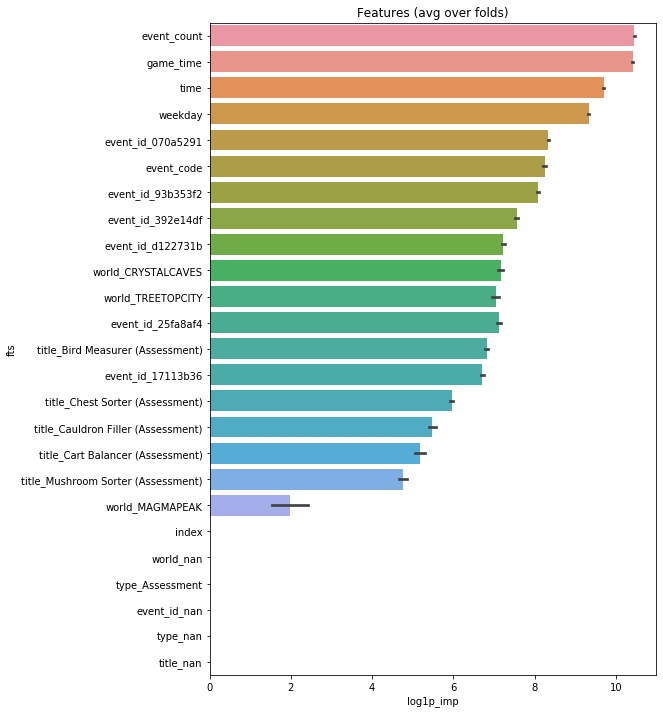

In [69]:
# Ploting stage 1 feature importances
cols = imp[["fts", "imp"]].groupby("fts").mean().sort_values(by="imp", ascending=False)[:60].index
imp['log1p_imp'] = np.log1p(imp['imp'])
best_features = imp.loc[imp.fts.isin(cols)]
plt.figure(figsize=(8, 12))
sns.barplot(x="log1p_imp", y="fts", data=best_features.sort_values(by="imp", ascending=False))
plt.title('Features (avg over folds)')

### Prepairing the Data

Putting the event_data breakdown on hold

In [13]:
# # Splitting out event_data into columns
# event_data_train = pd.DataFrame(X_train['event_data'].apply(json.loads).values.tolist())
# event_data_train.columns = [f"event_data.{col}" for col in event_data_train.columns]
# X_train = pd.concat([X_train, event_data_train],axis=1)
# X_train = X_train.drop(columns=['event_data', 'event_data.event_count', 'event_data.event_code'])
# X_train.head()

,event_id,game_session,timestamp,installation_id,event_count,event_code,game_time,title,type,world,...,event_data.molds,event_data.tape_length,event_data.bug_length,event_data.dwell_time,event_data.chests,event_data.target_size,event_data.object_type,event_data.group,event_data.max_position,event_data.end_position
0,27253bdc,a3325b38ad7292c1,2019-08-10T17:46:03.082Z,00e17272,1.0,2000.0,0.0,Welcome to Lost Lagoon!,Clip,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27253bdc,4d23feebc743419e,2019-08-10T17:46:18.684Z,00e17272,1.0,2000.0,0.0,Magma Peak - Level 1,Clip,MAGMAPEAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27253bdc,4b0eef97c4521434,2019-08-10T17:47:13.391Z,00e17272,1.0,2000.0,0.0,Magma Peak - Level 2,Clip,MAGMAPEAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27253bdc,c3e85417476eeae5,2019-08-10T17:47:51.101Z,00e17272,1.0,2000.0,0.0,Welcome to Lost Lagoon!,Clip,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27253bdc,9da134e1cb08364c,2019-08-10T17:48:21.252Z,00e17272,1.0,2000.0,0.0,Crystal Caves - Level 1,Clip,CRYSTALCAVES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# X_train.columns.values

array(['event_id', 'game_session', 'timestamp', 'installation_id',
       'event_count', 'event_code', 'game_time', 'title', 'type', 'world',
       'event_data.version', 'event_data.round', 'event_data.game_time',
       'event_data.coordinates', 'event_data.description',
       'event_data.identifier', 'event_data.media_type',
       'event_data.total_duration', 'event_data.duration',
       'event_data.dinosaur', 'event_data.diet',
       'event_data.target_weight', 'event_data.resources',
       'event_data.weight', 'event_data.source', 'event_data.correct',
       'event_data.scale_weight', 'event_data.scale_contents',
       'event_data.misses', 'event_data.tutorial_step',
       'event_data.dinosaur_weight', 'event_data.mode',
       'event_data.dinosaur_count', 'event_data.shells',
       'event_data.holes', 'event_data.holding_shell',
       'event_data.has_water', 'event_data.shell_size',
       'event_data.position', 'event_data.hole_position',
       'event_data.target_wate

In [15]:
# X_train.describe()

,event_count,event_code,game_time,event_data.round,event_data.game_time,event_data.total_duration,event_data.duration,event_data.target_weight,event_data.weight,event_data.scale_weight,...,event_data.containers,event_data.current_containers,event_data.total_containers,event_data.tape_length,event_data.bug_length,event_data.dwell_time,event_data.target_size,event_data.group,event_data.max_position,event_data.end_position
count,492271.000000,492271.000000,4.922710e+05,280842.000000,4.867190e+05,85975.000000,1.648240e+05,6337.000000,25134.000000,3725.000000,...,504.000000,2316.000000,2316.000000,7.0,7.0,44.000000,972.000000,1358.000000,56.000000,56.000000
mean,102.368338,3508.390807,1.730410e+05,6.442676,1.750149e+05,3684.223833,4.140505e+04,3.257535,2.873200,4.132617,...,4.611111,3.415803,5.622193,0.0,0.0,7190.113636,3.354938,3.313697,0.397661,0.382890
std,120.827067,678.246526,6.975832e+05,9.155236,7.013043e+05,3390.344814,7.289470e+05,2.018683,1.924208,2.163217,...,2.429842,2.183640,2.578732,0.0,0.0,15391.278493,0.934820,0.942865,0.447578,0.431906
min,1.000000,2000.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.0,0.0,1000.000000,2.000000,2.000000,0.000000,0.000000
25%,26.000000,3020.000000,3.001900e+04,1.000000,3.118500e+04,1633.000000,8.590000e+02,2.000000,1.000000,3.000000,...,2.000000,2.000000,3.000000,0.0,0.0,1666.750000,3.000000,3.000000,0.000000,0.000000
50%,61.000000,4020.000000,7.298000e+04,3.000000,7.425100e+04,2813.000000,1.967000e+03,3.000000,3.000000,4.000000,...,4.000000,3.000000,5.000000,0.0,0.0,2666.500000,3.000000,3.000000,0.058383,0.074162
75%,131.000000,4035.000000,1.590370e+05,7.000000,1.605000e+05,4733.000000,4.184000e+03,4.000000,3.000000,6.000000,...,6.000000,5.000000,8.000000,0.0,0.0,4423.250000,4.000000,4.000000,1.000000,0.899408
max,1125.000000,5010.000000,6.668400e+07,97.000000,6.668400e+07,44733.000000,3.141394e+07,11.000000,12.000000,8.000000,...,9.000000,9.000000,9.000000,0.0,0.0,91907.000000,5.000000,5.000000,1.000000,1.000000


In [16]:
# # Splitting out event_data into columns
# event_data_test = pd.DataFrame(X_test['event_data'].apply(json.loads).values.tolist())
# event_data_test.columns = [f"event_data.{col}" for col in event_data_test.columns]
# X_test = pd.concat([X_test, event_data_test],axis=1)
# X_test = X_test.drop(columns=['event_data', 'event_data.event_count', 'event_data.event_code'])
# X_test.shape

(165259, 130)

In [23]:
# X_train['event_data.end_position'].dropna().size # Some event columns are very sparse

56

In [25]:
# y_train.describe(include='all')

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
count,1276,1276,1276,1276.000000,1276.000000,1276.00000,1276.000000
unique,1276,97,5,NaN,NaN,NaN,NaN
top,56564b8cc798a982,08987c08,Cauldron Filler (Assessment),NaN,NaN,NaN,NaN
freq,1,156,316,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.703762,1.958464,0.52534,1.681818
std,NaN,NaN,NaN,0.456776,3.288578,0.43997,1.292761
min,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000
25%,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000
50%,NaN,NaN,NaN,1.000000,1.000000,0.50000,2.000000
75%,NaN,NaN,NaN,1.000000,3.000000,1.00000,3.000000


In [ ]:
# Too many values dont have the ram
# X_train, _ = one_hot_encoder(X_train, nan_as_category=True)

In [ ]:
# X_train['weekday'] = X_train.datetime.dt.weekday
# X_test['weekday'] = X_test.datetime.dt.weekday

# X_train['time']  = X_train.datetime.dt.hour
# X_test['time']  = X_test.datetime.dt.hour

# X_train['month'] = X_train.datetime.dt.month
# X_test['month'] = X_test.datetime.dt.month

# X_train['ordinal_date'] = [x.toordinal() for x in X_train.datetime]
# X_test['ordinal_date'] = [x.toordinal() for x in X_test.datetime]

# # Time since last and untill next event (we seem to have information about the future availible in the test set)
# X_train['time_prev_event'] = (
#         X_train.groupby('installation_id').datetime.shift(1) - X_train.datetime
#     ).astype(np.int64)//1e9//60//60
# X_test['time_prev_event'] = (
#         X_test.groupby('installation_id').datetime.shift(1) - X_test.datetime
#     ).astype(np.int64)//1e9//60//60

# Some event_codes are the same for different titles
# X_train['title.event_code'] = X_train[['title', 'event_code']].apply(lambda x: ''.join(str(x)), axis=1)
# X_test['title.event_code'] = X_test[['title', 'event_code']].apply(lambda x: ''.join(str(x)), axis=1)

# X_train.sort_values(by=['datetime'], inplace=True)
# X_test.sort_values(by=['datetime'], inplace=True)

# X_train['correct'] = X_train['event_data'].apply(lambda x: json.loads(x).get('correct'))
# X_test['correct'] = X_test['event_data'].apply(lambda x: json.loads(x).get('correct'))